<a href="https://colab.research.google.com/github/anoojsarvankar/stock-price-prediction/blob/master/SPP_CNN_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stock Price Prediction


##Importing Data

In [ ]:
import pandas as pd
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
keras=tf.keras
ICdata=pd.read_csv("https://raw.githubusercontent.com/anoojsarvankar/stock-price-prediction/master/ICICIBANK-NSE.csv")#Dataset extracted from yahoo finance for ICICI BANK for NSE
ICdata.tail(5)
def null_table(dataset):
  print("Dataset")
  print(pd.isnull(dataset).sum()) 

ICdata=ICdata.dropna()

null_table(ICdata)

Dataset
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


##Creating sequence

In [ ]:
trainset=ICdata['Open'].values
series=trainset

import numpy as np
time = np.arange(len(series))

split_time = int(len(series) * 0.80)

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
len(x_train)

390

In [ ]:
# def seq2seq_window_dataset(series, window_size, batch_size=32,
#                            shuffle_buffer=500):
#     series = tf.expand_dims(series, axis=-1)
#     ds = tf.data.Dataset.from_tensor_slices(series)
#     ds = ds.window(window_size + 1, shift=1, drop_remainder=True) #65sizewindows*326times cuz shift 1  
#     ds = ds.flat_map(lambda w: w.batch(window_size + 1)) #array of 2D arrays
#     ds = ds.shuffle(shuffle_buffer)
#     ds = ds.map(lambda w: (w[:-1], w[1:])) #[array(array([[seq of features]]),array([[seq of labels/output]]))*326(for each window)]
#     return ds.batch(batch_size).prefetch(1)

# window_size = 64
# train_set = seq2seq_window_dataset(x_train, window_size,
#                                    batch_size=128)    

##Model and data compatibility

In [ ]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=500):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

from keras.layers import LSTM, Dense, Input, TimeDistributed, Masking , Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from keras import Sequential

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 1)           3

##Finding approriate Learning rate

In [ ]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
3/3 [==============================] - 0s 37ms/step - loss: 361.3108 - mae: 361.3618 - lr: 1.0000e-04
Epoch 2/100
3/3 [==============================] - 0s 6ms/step - loss: 360.4135 - mae: 360.0287 - lr: 1.0798e-04
Epoch 3/100
3/3 [==============================] - 0s 7ms/step - loss: 358.2021 - mae: 358.6986 - lr: 1.1659e-04
Epoch 4/100
3/3 [==============================] - 0s 7ms/step - loss: 356.9658 - mae: 357.4035 - lr: 1.2589e-04
Epoch 5/100
3/3 [==============================] - 0s 6ms/step - loss: 355.6789 - mae: 356.2505 - lr: 1.3594e-04
Epoch 6/100
3/3 [==============================] - 0s 7ms/step - loss: 354.6725 - mae: 354.9990 - lr: 1.4678e-04
Epoch 7/100
3/3 [==============================] - 0s 6ms/step - loss: 352.0746 - mae: 353.4742 - lr: 1.5849e-04
Epoch 8/100
3/3 [==============================] - 0s 6ms/step - loss: 350.9494 - mae: 351.6918 - lr: 1.7113e-04
Epoch 9/100
3/3 [==============================] - 0s 6ms/step - loss: 349.4262 - mae: 349.6306

(0.0001, 0.1, 0.0, 30.0)

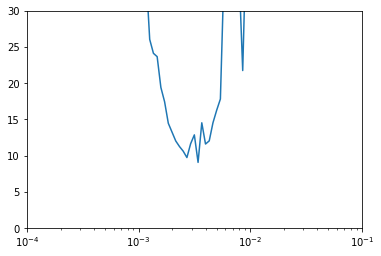

In [ ]:
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

##Training
Fitting the data with LR -> 0.001

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
3/3 [==============================] - 1s 182ms/step - loss: 343.5299 - mae: 344.6008 - val_loss: 486.0612 - val_mae: 486.5612
Epoch 2/500
3/3 [==============================] - 0s 31ms/step - loss: 322.2285 - mae: 323.4155 - val_loss: 445.6472 - val_mae: 446.1472
Epoch 3/500
3/3 [==============================] - 0s 33ms/step - loss: 291.0281 - mae: 293.6571 - val_loss: 388.6415 - val_mae: 389.1415
Epoch 4/500
3/3 [==============================] - 0s 34ms/step - loss: 247.5869 - mae: 251.1218 - val_loss: 306.4719 - val_mae: 306.9719
Epoch 5/500
3/3 [==============================] - 0s 40ms/step - loss: 185.4707 - mae: 190.2440 - val_loss: 223.8133 - val_mae: 224.3124
Epoch 6/500
3/3 [==============================] - 0s 21ms/step - loss: 145.2908 - mae: 145.5086 - val_loss: 231.9249 - val_mae: 232.4248
Epoch 7/500
3/3 [==============================] - 0s 17ms/step - loss: 153.1533 - mae: 153.6763 - val_loss: 240.6945 - val_mae: 241.1942
Epoch 8/500
3/3 [================

##Using the trained model for prediction

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

##Result

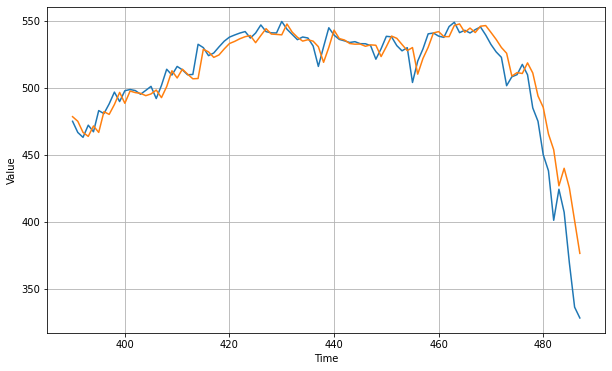

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)